In [2]:
import scanpy as sc

In [3]:
import pandas as pd

In [4]:
import flowsig as fs

2025-05-30 07:05:44.743274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748588744.966413  252760 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748588745.042659  252760 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748588745.559023  252760 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748588745.559050  252760 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748588745.559054  252760 computation_placer.cc:177] computation placer alr

In [ ]:
adata = sc.read('onc_flowsig.h5ad')

In [1019]:
adata_onc13 = adata[adata.obs['orig.ident'].isin(['onc1','onc3']), :].copy()

In [7]:
adata_onc12 = sc.read('onc_lif12.h5ad')

In [1020]:
adata_onc12 = adata[adata.obs['orig.ident'].isin(['onc1','onc2']), :].copy()

In [1021]:
condition_key = 'orig.ident'

In [1022]:
cellchat_Ctrl = pd.read_csv('communications_ctrl.csv')
cellchat_Onc2h = pd.read_csv('communications_onc2h.csv')
cellchat_Onc8h = pd.read_csv('communications_onc8h.csv')
cellchat_Onc1d = pd.read_csv('communications_onc1d.csv')
cellchat_Onc3d = pd.read_csv('communications_onc3d.csv')
cellchat_Onc7d = pd.read_csv('communications_onc7d.csv')

In [1023]:
cellchat_output_key = 'cellchat_output'

In [1024]:
adata.uns[cellchat_output_key] = {'onc1': cellchat_Ctrl,  'onc2': cellchat_Onc2h,  'onc3': cellchat_Onc8h,  'onc4': cellchat_Onc1d,  'onc5': cellchat_Onc3d,  'onc6': cellchat_Onc7d}

In [1025]:
adata_onc12.uns[cellchat_output_key] = {'onc1': cellchat_Ctrl,  'onc2': cellchat_Onc2h}

In [127]:
adata = sc.read('onc_gem0422.h5ad')

In [ ]:
fs.pp.construct_flow_expressions(adata,
                                cellchat_output_key=cellchat_output_key,
                                model_organism = 'mouse',
                                spatial = False,
                                method = 'cellchat'
                                )

In [61]:
import pandas as pd

# 提取 GEM 表达
gems = pd.DataFrame(adata.obsm['X_gem'], 
                    columns=[f'GEM{i+1}' for i in range(adata.obsm['X_gem'].shape[1])],
                    index=adata.obs_names)  # 保留细胞 ID 为行名

# 添加 index 列（供 R 中合并）
gems.reset_index(inplace=True)
gems.rename(columns={'index': 'cell_id'}, inplace=True)

# 保存为 CSV 文件
gems.to_csv("adata_X_gem.csv", index=False)

In [ ]:
from flowsig.preprocessing._flow_expressions import (
    construct_outflow_signals_cellchat,
    construct_inflow_signals_cellchat,
    construct_gem_expressions,
    FlowSigConfig
)

# 1. Outflow
adata_outflow, _ = construct_outflow_signals_cellchat(
    adata, cellchat_output_key=cellchat_output_key
)
print("OUTFLOW .var columns:", adata_outflow.var.columns.tolist())
print(adata_outflow.var.head())

# 2. Inflow
adata_inflow, _ = construct_inflow_signals_cellchat(
    adata,
    cellchat_output_key=cellchat_output_key,
    model_organism='mouse'
)
print("INFLOW .var columns:", adata_inflow.var.columns.tolist())
print(adata_inflow.var.head())

# 3. GEM
cfg = FlowSigConfig()
adata_gem, _ = construct_gem_expressions(
    adata,
    config=cfg
)
print("GEM .var columns:", adata_gem.var.columns.tolist())
print(adata_gem.var.head())

In [ ]:
cell_names = pd.read_csv('cell_names.csv', header=None).squeeze()
gene_names = pd.read_csv('gene_names.csv', header=None).squeeze()

In [ ]:
cell_names = cell_names[1:]

In [ ]:
gene_names = gene_names[1:]

adata.obs.index = cell_names
adata.var.index = gene_names

In [ ]:
adata.obs.index.name = 'Cell_ID'

In [ ]:
adata.var.index.name = 'Gene_ID'

In [ ]:
fs.pp.construct_gems_using_pyliger(adata_onc12,
                                n_gems = 10,
                                layer_key = 'counts',
                                condition_key = condition_key)

In [ ]:
adata_onc12.write('onc_gem12.h5ad')

In [ ]:
fs.pp.construct_flow_expressions(adata_onc12,
                                cellchat_output_key=cellchat_output_key,
                                model_organism = 'mouse',
                                spatial = False,
                                method = 'cellchat'
                                )

In [ ]:

adata_onc12.write('onc_cfe12.h5ad')

In [ ]:
fs.pp.determine_informative_variables(
    adata_onc12,
    spatial       = False,
    condition_key = 'orig.ident',
    control       = 'onc1',
    logfc_thr     = 0.5,
    qval_thr      = 0.05
)

In [ ]:
adata_onc12.write('onc_div12.h5ad')

In [ ]:
fs.tl.learn_intercellular_flows(
    adata_onc12,
    condition_key = condition_key,
    control       = 'onc1',
    use_spatial   = False,
    n_jobs        = 32,
    n_bootstraps  = 200,
    alpha_ci      = 0.05,   # bootstrap 置信区间下限/上限用的 alpha
    alpha_inv     = 0.5     # 邀请阈值，例如保留 A 中大于 0.5 的边
)

In [ ]:
import numpy as np
n_sub = 8000
idx = np.random.choice(adata.n_obs, size=n_sub, replace=False)
adata_sub = adata[idx].copy()

# 然后在子集上跑原来的流程
fs.pp.determine_informative_variables(
    adata_sub,
    spatial       = False,
    condition_key = 'orig.ident',
    control       = 'onc1',
    logfc_thr     = 0.5,
    qval_thr      = 0.05,
    method        = 'wilcoxon'
)
fs.tl.learn_intercellular_flows(
    adata_sub,
    condition_key = 'orig.ident',
    control       = 'onc1',
    use_spatial   = False,
    n_jobs        = 16,
    n_bootstraps  = 200,     # 少一点
    alpha_ci      = 0.05,
    alpha_inv     = 0.5
)

In [ ]:
import copy
from pathlib import Path

# 1. 复制（AnnData.copy() 已经深拷贝 .uns；这里再 copy.deepcopy 保守处理）
adata_save = adata_onc12.copy()
adata_save.uns = copy.deepcopy(adata_onc12.uns)

# 2. 把所有字典键转成字符串
def stringify_keys(obj):
    if isinstance(obj, dict):
        return {str(k): stringify_keys(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [stringify_keys(x) for x in obj]
    else:
        return obj

adata_save.uns = stringify_keys(adata_save.uns)

# 3. 保存
out = Path("onc_lif12.h5ad")
adata_save.write(out)
print(f"Saved to {out.resolve()}")

In [100]:
adata_onc12 = sc.read('onc_lif12.h5ad')

In [101]:
fs.tl.apply_biological_flow(
    adata_onc12,
    adjacency_key       = 'adjacency',
    validated_key       = 'validated'
)

In [102]:
fs.tl.filter_low_confidence_edges(
    adata_onc12,
    edge_threshold       = 0.5,
    flowsig_network_key  = 'flowsig_network',
    adjacency_key        = 'adjacency_validated',
    filtered_key         = 'filtered'
)

In [ ]:
import pandas as pd

# 读取 CSV 文件
ident_df = pd.read_csv("active_ident.csv")

# 假设 'Cell_ID' 是细胞的名称，将它设为索引
ident_df.set_index('Cell_ID', inplace=True)

# 确保 adata 和 ident_df 的索引一致（通常是细胞名称）
# 将 active.ident 加入到 adata.obs 中
adata.uns['active_ident'] = ident_df.loc[adata.obs_names, 'ident_values']

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import scanpy as sc
from typing import Union, Sequence

In [ ]:
# 获取行名（细胞名称）
row_names = adata.obs_names
print("行名（细胞）：", row_names)

# 获取列名（基因或特征名称）
col_names = adata.var_names
print("列名（基因或特征）：", col_names)

In [ ]:
adata.uns['pyliger_info']['n_gems']

In [ ]:
gem_data = adata.obsm['X_gem']

In [ ]:
print(gem_data.shape) 

In [ ]:
module_names = [f"GEM-{i+1}" for i in range(10)]
gem_df = pd.DataFrame(gem_data, index=row_names, columns=module_names)
print(gem_df)

In [ ]:
gem_df.to_csv("gem_df.csv", index=True)

In [ ]:
adata.uns['pyliger_info']

In [ ]:
print(adata.uns['pyliger_info'].keys())

In [ ]:
import pandas as pd
import numpy as np

# 获取 GEM 表达矩阵
X_gem = adata.obsm['X_gem']  # 每个细胞在 GEM 中的表达

# 创建一个字典来存储每个 GEM 及其对应的基因
gem_genes = {}

# 获取基因名称
gene_names = adata.var.index.tolist()

# 遍历 pyliger_info 中的条件
for cond in adata.uns['pyliger_info'].keys():
    if cond not in ['n_gems', 'vars']:  # 跳过不相关的键
        # 获取当前条件的 W 矩阵
        W = adata.uns['pyliger_info'][cond]['W']  # 从每个条件中提取 W 矩阵

        # 假设 W 是一个 (num_genes, num_gems) 的矩阵
        num_gems = W.shape[1]

        for gem_idx in range(num_gems):
            # 获取当前 GEM 的权重
            gem_weights = W[:, gem_idx]

            # 找出权重大于某个阈值的基因索引
            threshold = 0  # 可以调整这个阈值
            gene_indices = np.where(gem_weights > threshold)[0]

            # 获取这些基因的名称和权重
            important_genes = [(gene_names[i], gem_weights[i]) for i in gene_indices]

            # 按权重排序，获取前 10 个基因
            important_genes.sort(key=lambda x: x[1], reverse=True)  # 按权重降序排序
            top_genes = important_genes[:20]  # 选择前 10 个基因

            # 存储结果
            gem_genes[f'{cond}_GEM-{gem_idx + 1}'] = top_genes

# 打印每个 GEM 中最重要的十个基因
for gem, genes in gem_genes.items():
    gene_names_list = [gene[0] for gene in genes]  # 提取基因名称
    print(f"{gem}: {', '.join(gene_names_list)}")

In [ ]:
import pandas as pd
import numpy as np

# 获取 GEM 表达矩阵
X_gem = adata.obsm['X_gem']  # 每个细胞在 GEM 中的表达

# 创建一个字典来存储每个 GEM 及其对应的基因
gem_genes = {}

# 获取基因名称
gene_names = adata.var.index.tolist()

# 遍历 pyliger_info 中的条件
for cond in adata.uns['pyliger_info'].keys():
    if cond not in ['n_gems', 'vars']:  # 跳过不相关的键
        # 获取当前条件的 W 矩阵
        W = adata.uns['pyliger_info'][cond]['W']  # 从每个条件中提取 W 矩阵

        # 假设 W 是一个 (num_genes, num_gems) 的矩阵
        num_gems = W.shape[1]

        for gem_idx in range(num_gems):
            # 获取当前 GEM 的权重
            gem_weights = W[:, gem_idx]

            # 找出权重大于某个阈值的基因索引
            threshold = 0  # 可以调整这个阈值
            gene_indices = np.where(gem_weights > threshold)[0]

            # 获取这些基因的名称和权重
            important_genes = [(gene_names[i], gem_weights[i]) for i in gene_indices]

            # 按权重排序，获取前 20 个基因
            important_genes.sort(key=lambda x: x[1], reverse=True)  # 按权重降序排序
            top_genes = important_genes[:100]  # 选择前 20 个基因

            # 存储结果
            gem_genes[f'{cond}_GEM-{gem_idx + 1}'] = top_genes

# 创建一个 DataFrame 来保存基因和权重数据
gene_weight_data = []

# 遍历每个 GEM，收集基因和权重
for cond in gem_genes.keys():
    for gene, weight in gem_genes[cond]:
        gene_weight_data.append({'GEM': cond, 'Gene': gene, 'Weight': weight})

# 创建 DataFrame
gene_weight_df = pd.DataFrame(gene_weight_data)

# 保存为 CSV 文件
gene_weight_df.to_csv('gem_genes_weights.csv', index=True)


In [ ]:
gene_weight_df

In [ ]:
plt.show()

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import scanpy as sc
import numpy as np 
import pandas as pd
from typing import Union, Sequence, List, Tuple, Optional, Iterable
from matplotlib.axes import Axes

In [104]:
import copy  
from anndata import AnnData
fvi_unique = (
    adata_onc12.uns['flowsig_network']['flow_var_info']
      .groupby(level=0, sort=False)          # 每个 node 一组
      .first()                               # 保留第一条（可换成 mean()/median() 等聚合）
      .copy()
)

# 2. 构造一个轻量 AnnData 视图，矩阵沿用原内存
adata_view = AnnData(
    X      = adata_onc12.X,
    obs    = adata_onc12.obs,
    var    = adata_onc12.var,
    layers = adata_onc12.layers,
    obsm   = adata_onc12.obsm,
    varm   = adata_onc12.varm,
    obsp   = adata_onc12.obsp,
    varp   = adata_onc12.varp,
    uns    = copy.deepcopy(adata_onc12.uns),       # 仅 .uns 需要深拷贝
)
adata_view.uns['flowsig_network']['flow_var_info'] = fvi_unique   # 覆盖为唯一索引版

In [103]:
flow_network = fs.tl.construct_intercellular_flow_network(adata_onc12,
                                                        flowsig_network_key = 'flowsig_network',
                                                        adjacency_key = 'adjacency_validated_filtered')

In [105]:
import copy
import matplotlib.pyplot as plt

# 1. 深拷贝并清洗 flow_var_info
fvi = adata_view.uns['flowsig_network']['flow_var_info']
fvi_clean = fvi.copy()

# 去空格：索引和 Interaction（如有必要）都 strip
idx = fvi_clean.index.to_series().str.strip()
fvi_clean.index = idx
# 如果 Interaction 里也有空格：
# fvi_clean['Interaction'] = fvi_clean['Interaction'].str.strip()

# 去重：保留第一次出现
fvi_clean = fvi_clean[~fvi_clean.index.duplicated(keep='first')]

# 2. 挂回到一个新的 AnnData 视图
adata_clean = adata_view.copy()
adata_clean.uns = copy.deepcopy(adata_view.uns)
adata_clean.uns['flowsig_network']['flow_var_info'] = fvi_clean

# 3. **从 fvi_clean 自动生成三组干净的变量列表**
inflow_vars  = [node for node, t in zip(fvi_clean.index, fvi_clean['Type']) if t=='inflow']
module_vars  = [node for node, t in zip(fvi_clean.index, fvi_clean['Type']) if t=='module']
outflow_vars = [node for node, t in zip(fvi_clean.index, fvi_clean['Type']) if t=='outflow']

import networkx as nx

# 1. 构造旧→新名称映射（strip 首尾空格）
mapping = {node: node.strip() for node in flow_network.nodes()}

# 2. 利用 networkx.relabel_nodes 快速重命名
flow_network_clean = nx.relabel_nodes(flow_network, mapping, copy=True)

# 3. 只保留在 fvi_clean.index（你清洗后）的那些节点
keep = set(fvi_clean.index)
flow_network_clean = flow_network_clean.subgraph(keep).copy()
valid_nodes = set(flow_network_clean.nodes())

def filter_vars(lst, valid):
    bad = set(lst) - valid
    if bad:
        print(f"Dropping {len(bad)} missing nodes:", bad)
    return [n for n in lst if n in valid]

inflow_vars  = filter_vars(inflow_vars, valid_nodes)
module_vars  = filter_vars(module_vars, valid_nodes)
outflow_vars = filter_vars(outflow_vars, valid_nodes)

print(f"→ inflow: {len(inflow_vars)} nodes, module: {len(module_vars)}, outflow: {len(outflow_vars)}")

Dropping 4 missing nodes: {'L1cam', 'Lrp8', 'Cd36', 'Vldlr'}
Dropping 1 missing nodes: {'Kitl'}
→ inflow: 10 nodes, module: 10, outflow: 6


In [112]:
import matplotlib as mpl

mpl.rcParams.update({
    # 文本字体
    'font.size':           12,   # 基本文字大小
    'axes.titlesize':      14,   # 标题
    'axes.labelsize':      12,   # 坐标轴标签
    'xtick.labelsize':     10,   # 刻度文字
    'ytick.labelsize':     10,
    'legend.fontsize':     10,

    # 线条和节点
    'lines.linewidth':     1.5,  # 如果 flowsig 用 plot 画边
    'lines.markersize':    6,    # 如果你后续有散点

})

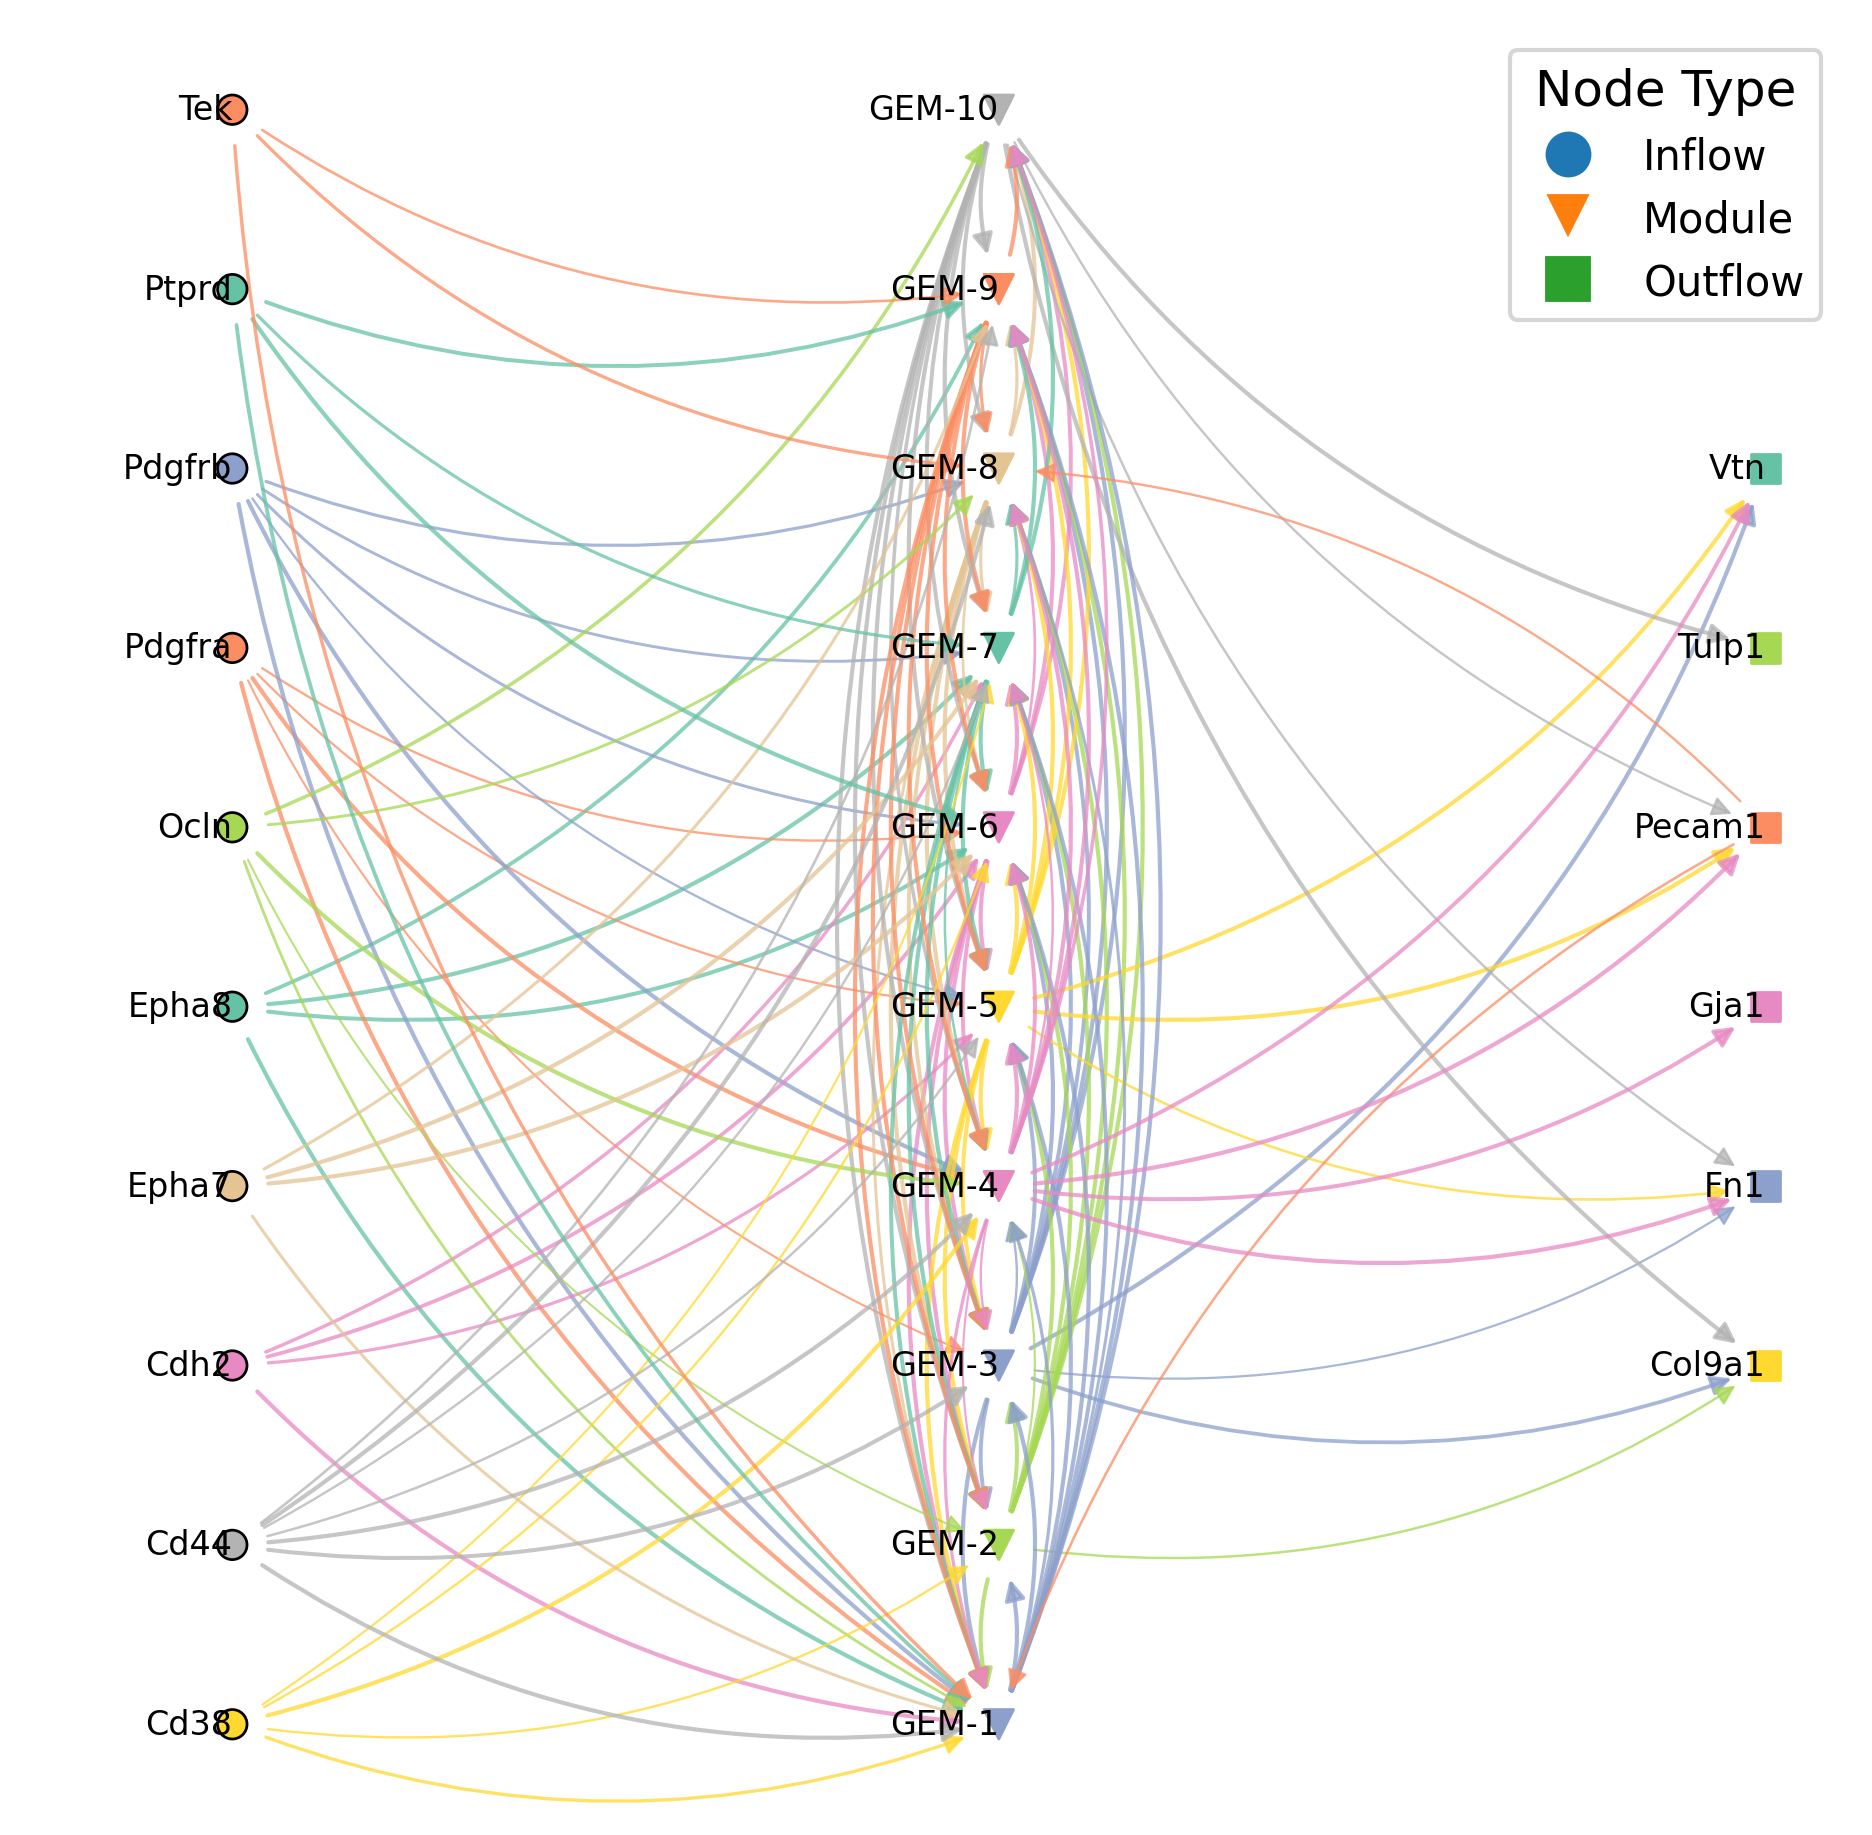

In [119]:
from matplotlib.collections import PathCollection
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

fig, ax = plt.subplots(dpi=300)

fs.pl.plot_intercellular_flows(
    adata_clean,
    flow_network        = flow_network_clean,
    flowsig_network_key = 'flowsig_network',
    align_mode          = 'vertical',
    inflow_vars         = inflow_vars,
    module_vars         = module_vars,
    outflow_vars        = outflow_vars,
    width_scale         = 1.0,
    x_margin_offset     = 0.0,   # ← 左右再留点空
    y_margin_offset     = 0.0,   # ← 上下再留点空
    ax                  = ax,
)
for txt in ax.texts:
    txt.set_fontsize(8)
    txt.set_rotation(0)               # 水平
    txt.set_horizontalalignment("right")
    
# 调整所有文本大小
for txt in ax.texts:
    x, y = txt.get_position()
    txt.set_position((x, y ))

# —— 把所有节点圆点缩小一些 —— #
# 定义你想要的大小
SIZE_IN  = 200
SIZE_MOD = 50
SIZE_OUT = 50

# 重新给每个 PathCollection 定大小
for coll in ax.collections:
    if not isinstance(coll, PathCollection):
        continue
    coords = coll.get_offsets()  # numpy array of shape (n_points, 2)
    xs = coords[:,0]
    coll.set_linewidths(0.66)
    # 根据 x 坐标决定这组点是 inflow/module/outflow
    if xs.mean() < -0.5:          # 根据你的 X_SPACING 适当调整阈值
        coll.set_sizes([SIZE_IN])
    elif xs.mean() >  0.5:
        coll.set_sizes([SIZE_OUT])
    else:
        coll.set_sizes([SIZE_MOD])

fig.set_figheight(6.4)
fig.set_figwidth(6.4)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Inflow',
           markerfacecolor='tab:blue', markersize=12),
    Line2D([0], [0], marker='v', color='w', label='Module',
           markerfacecolor='tab:orange', markersize=12),
    Line2D([0], [0], marker='s', color='w', label='Outflow',
           markerfacecolor='tab:green', markersize=12)
]

# 添加图例到已有 ax
ax.legend(handles=legend_elements, loc='upper right', title='Node Type')
plt.show()

In [91]:
# —— 2) 调色板补丁 ——#
# 推荐直接用布尔索引计算每种类型节点数，避免 query 字符串错误
import math
fvi = adata_clean.uns['flowsig_network']['flow_var_info']
n_inflow  = (fvi['Type'] == 'inflow').sum()
n_module  = (fvi['Type'] == 'module').sum()
n_outflow = (fvi['Type'] == 'outflow').sum()
n_nodes   = n_inflow + n_module + n_outflow

# 生成浅色 Set2 调色板，长度至少 n_nodes
base    = sns.color_palette("Set2", 20)
repeat  = math.ceil(n_nodes / len(base))
fsp.palette_network = (base * repeat)[:n_nodes]

In [25]:
# 1) 恢复 Matplotlib 的 rcParams 到默认值
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# 2) 如果你覆盖过 palette_network，也一起恢复
import flowsig.plotting._plotting as fsp
import importlib
importlib.reload(fsp)   # 重载模块，palette_network 会回到源码里定义的那个

# 3) 恢复 networkx 的 multipartite_layout 到官方默认
import networkx.drawing.layout as layout
import importlib
importlib.reload(layout)

# 4) 再次重载 FlowSig plotting，确保它拿到网络画图库刚刚重载的版本
importlib.reload(fsp)

<module 'flowsig.plotting._plotting' from '/home/savall/flowsig/flowsig/plotting/_plotting.py'>

In [90]:
import networkx as nx

# flow_network_clean 是一个 NetworkX 图
n_nodes = len(flow_network_clean.nodes)
print("需要颜色数:", n_nodes)

需要颜色数: 102


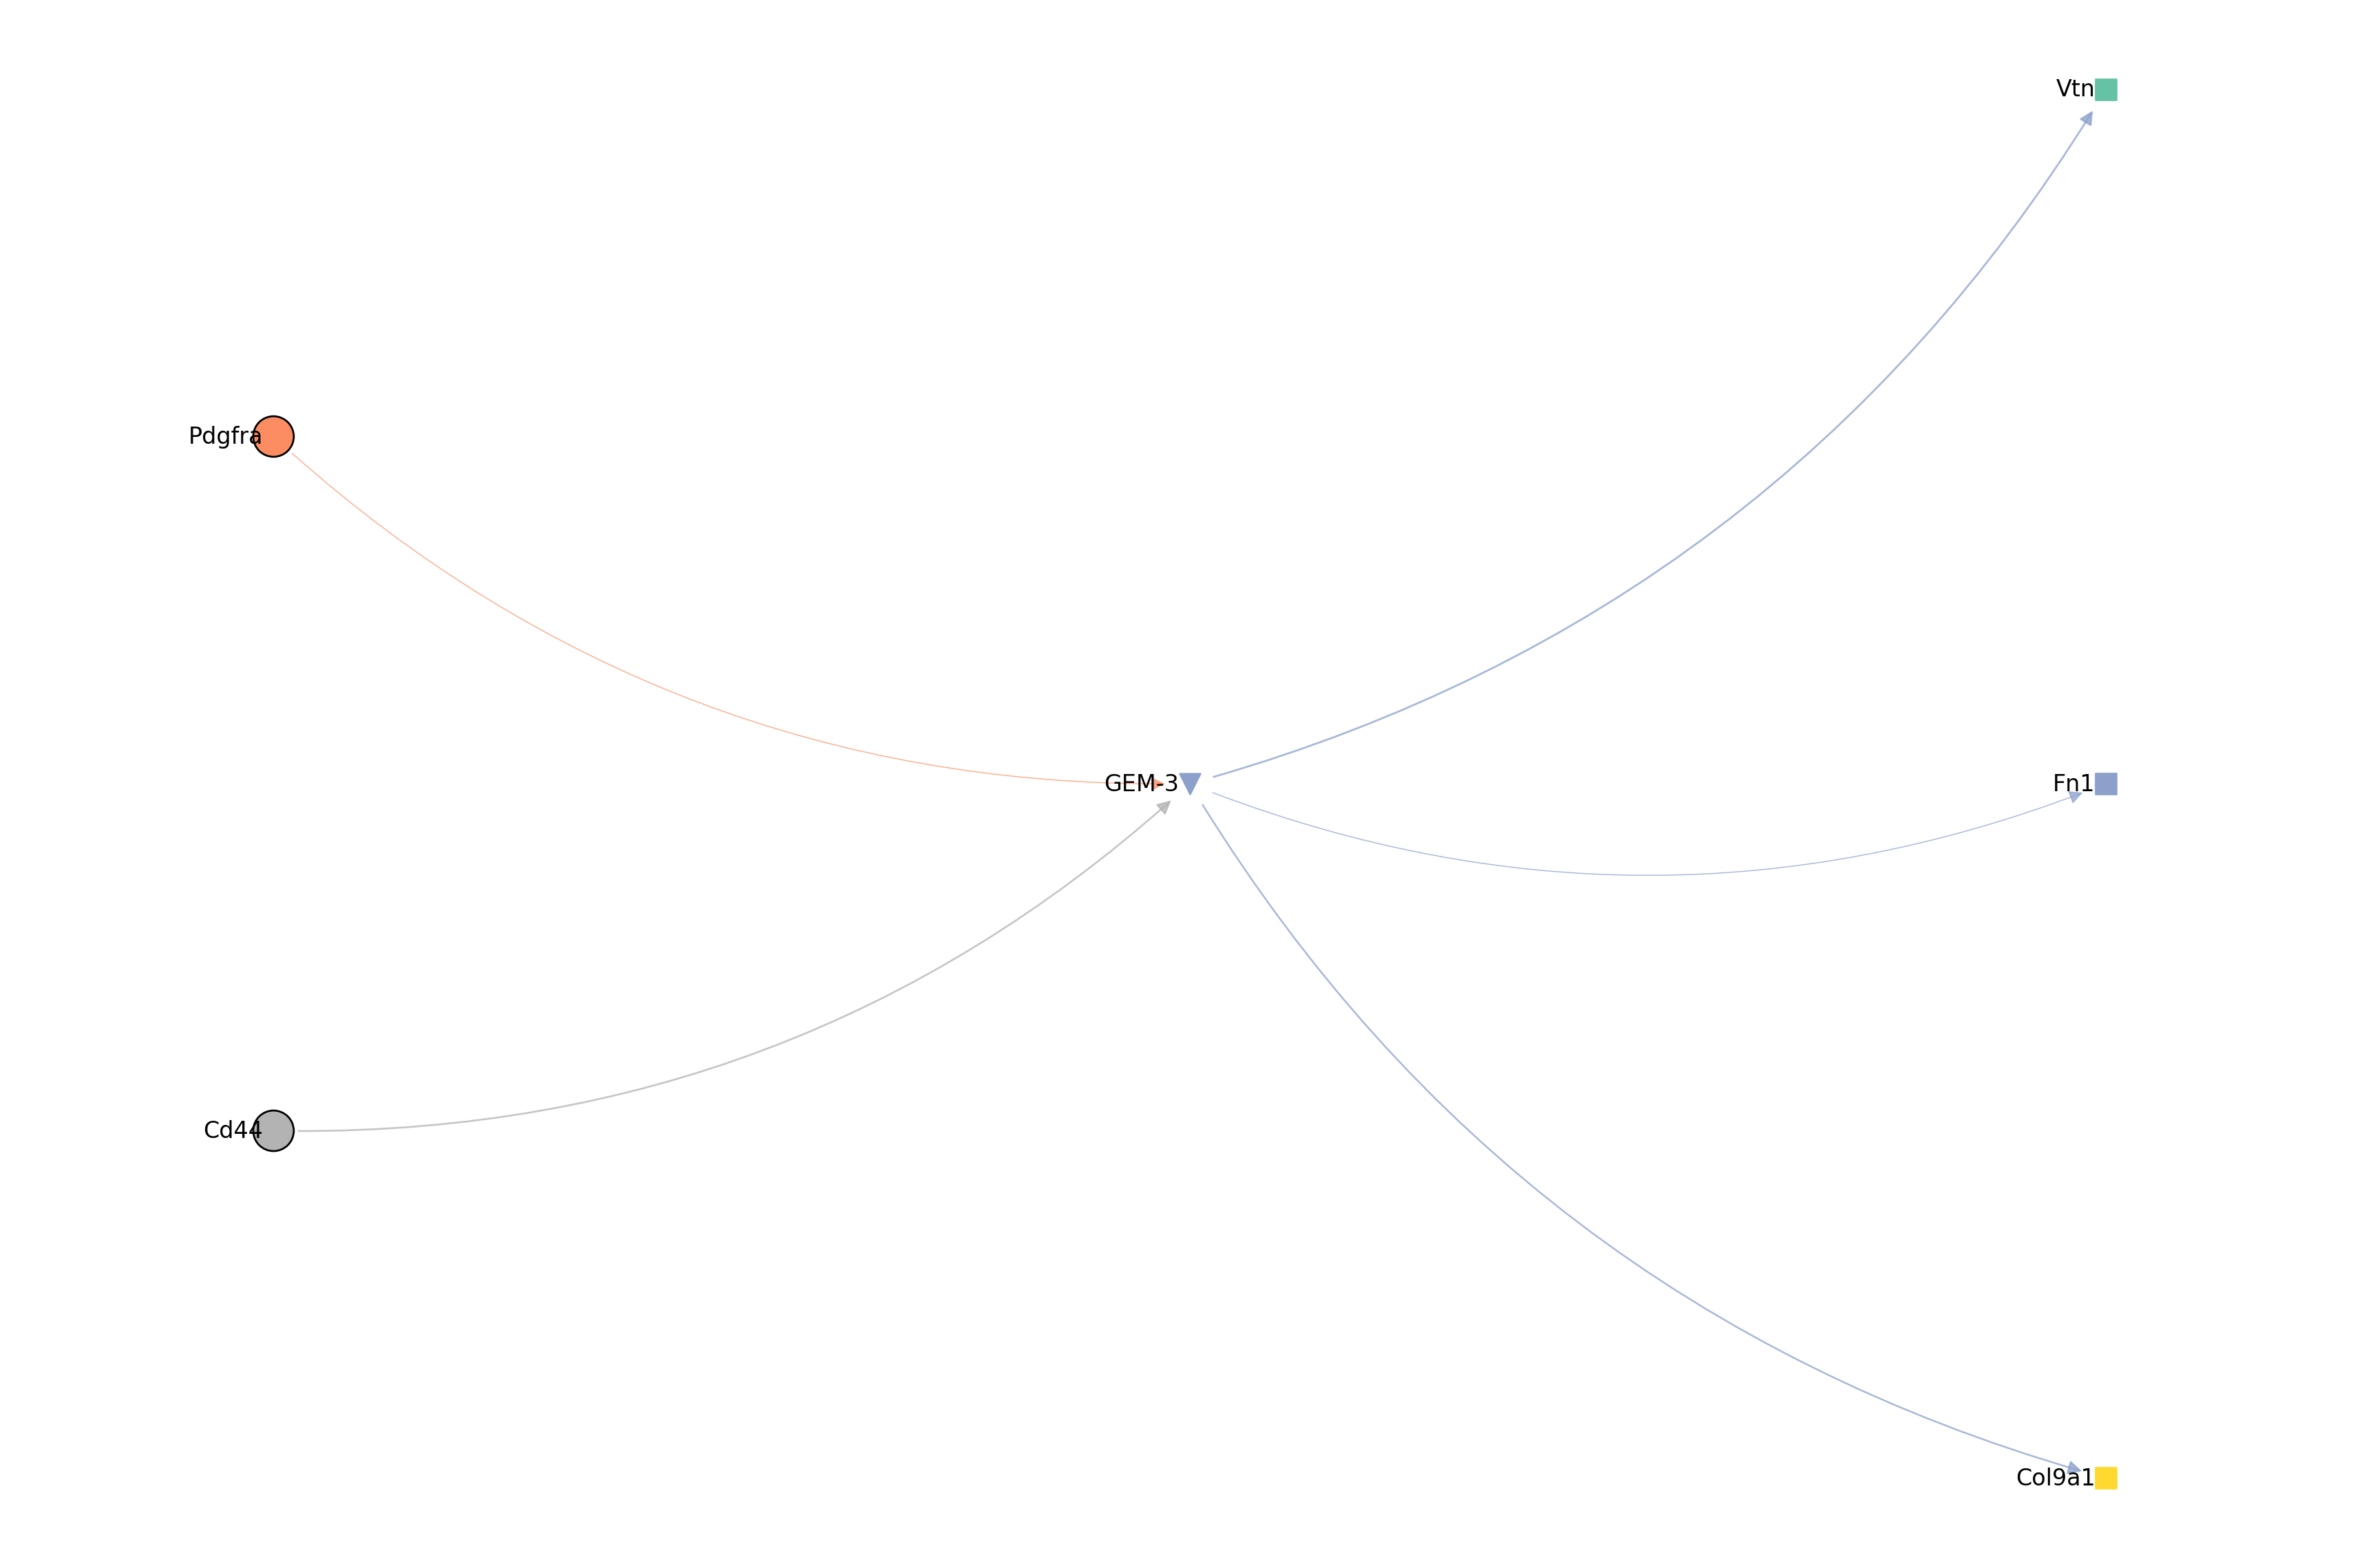

In [106]:
from adjustText import adjust_text
fig, ax = plt.subplots(dpi=300)

fs.pl.plot_intercellular_flows(
    adata_clean,
    flow_network        = flow_network_clean,
    flowsig_network_key = 'flowsig_network',
    module_vars         = ['GEM-3'],
    align_mode          = 'vertical',
    width_scale         = 0.66,
    x_margin_offset     = 0.08,   # ← 左右再留点空
    y_margin_offset     = 0.0,   # ← 上下再留点空
    ax                  = ax,
)
for txt in ax.texts:
    txt.set_fontsize(8)
    txt.set_rotation(0)               # 水平
    txt.set_horizontalalignment("right")
    
# 调整所有文本大小
for txt in ax.texts:
    x, y = txt.get_position()
    txt.set_position((x-0.02, y ))

# —— 把所有节点圆点缩小一些 —— #
# 定义你想要的大小
SIZE_IN  = 200
SIZE_MOD = 50
SIZE_OUT = 50

# 重新给每个 PathCollection 定大小
for coll in ax.collections:
    if not isinstance(coll, PathCollection):
        continue
    coords = coll.get_offsets()  # numpy array of shape (n_points, 2)
    xs = coords[:,0]
    coll.set_linewidths(0.66)
    # 根据 x 坐标决定这组点是 inflow/module/outflow
    if xs.mean() < -0.5:          # 根据你的 X_SPACING 适当调整阈值
        coll.set_sizes([SIZE_IN])
    elif xs.mean() >  0.5:
        coll.set_sizes([SIZE_OUT])
    else:
        coll.set_sizes([SIZE_MOD])

fig.set_figheight(8)
fig.set_figwidth(12)

plt.show()


In [ ]:
fvi = adata.uns['flowsig_network']['flow_var_info']

# 看前几行的数据长什么样
print("=== 前 5 行 ===")
print(fvi.head(), "\n")

# 看一下它的列名
print("=== 列名 ===")
print(fvi.columns.tolist(), "\n")

# 看一下索引前 20 个节点的名字
print("=== 索引示例 ===")
for idx in fvi.index[:20]:
    print(idx)

In [ ]:
# 1. 取出 flow_var_info
fvi = adata_view.uns['flowsig_network']['flow_var_info']

# 2. 查看索引是否唯一
print("索引是否唯一？", fvi.index.is_unique)

# 3. 显示所有 flow_var_info
print("\n=== 全部 flow_var_info ===")
print(fvi.to_string())        # Jupyter 环境下直接 fvi 也会渲染成表格

# 4. 找出并显示索引重复的条目
duplicates = fvi[fvi.index.duplicated(keep=False)]
print("\n=== 索引重复的 flow_var_info 条目 ===")
print(duplicates.to_string())

In [128]:
adata.uns["cellchat_output"]

{'onc1':       Unnamed: 0             source               target  ligand   receptor  \
 0              1             Muller  Microglia_Activated   Tgfb2  TGFbR1_R2   
 1              2            Bipolar  Microglia_Activated   Tgfb2  TGFbR1_R2   
 2              3          Astrocyte  Microglia_Activated   Tgfb2  TGFbR1_R2   
 3              4  Microglia_Resting  Microglia_Activated   Tgfb3  TGFbR1_R2   
 4              5                RGC               Muller    Fgf1      Fgfr1   
 ...          ...                ...                  ...     ...        ...   
 5351        5352           Amacrine            Astrocyte   Cntn1     Notch2   
 5352        5353  Microglia_Resting            Astrocyte   Cntn1     Notch2   
 5353        5354         Horizontal            Astrocyte   Cntn1     Notch2   
 5354        5355          Astrocyte            Astrocyte   Cntn1     Notch2   
 5355        5356        Endothelial            Astrocyte  Pecam1       Cd38   
 
           prob  pval     inte

Pairs with Control=0 and increasing at 8h,24h,72h,168h:


time_h,0,2,8,24,72,168,Δ8h,Δ24h,Δ72h,Δ168h,sum(Δ)
pair,,,,,,,,,,,



Top 5:


time_h,0,2,8,24,72,168,Δ8h,Δ24h,Δ72h,Δ168h,sum(Δ)
pair,,,,,,,,,,,


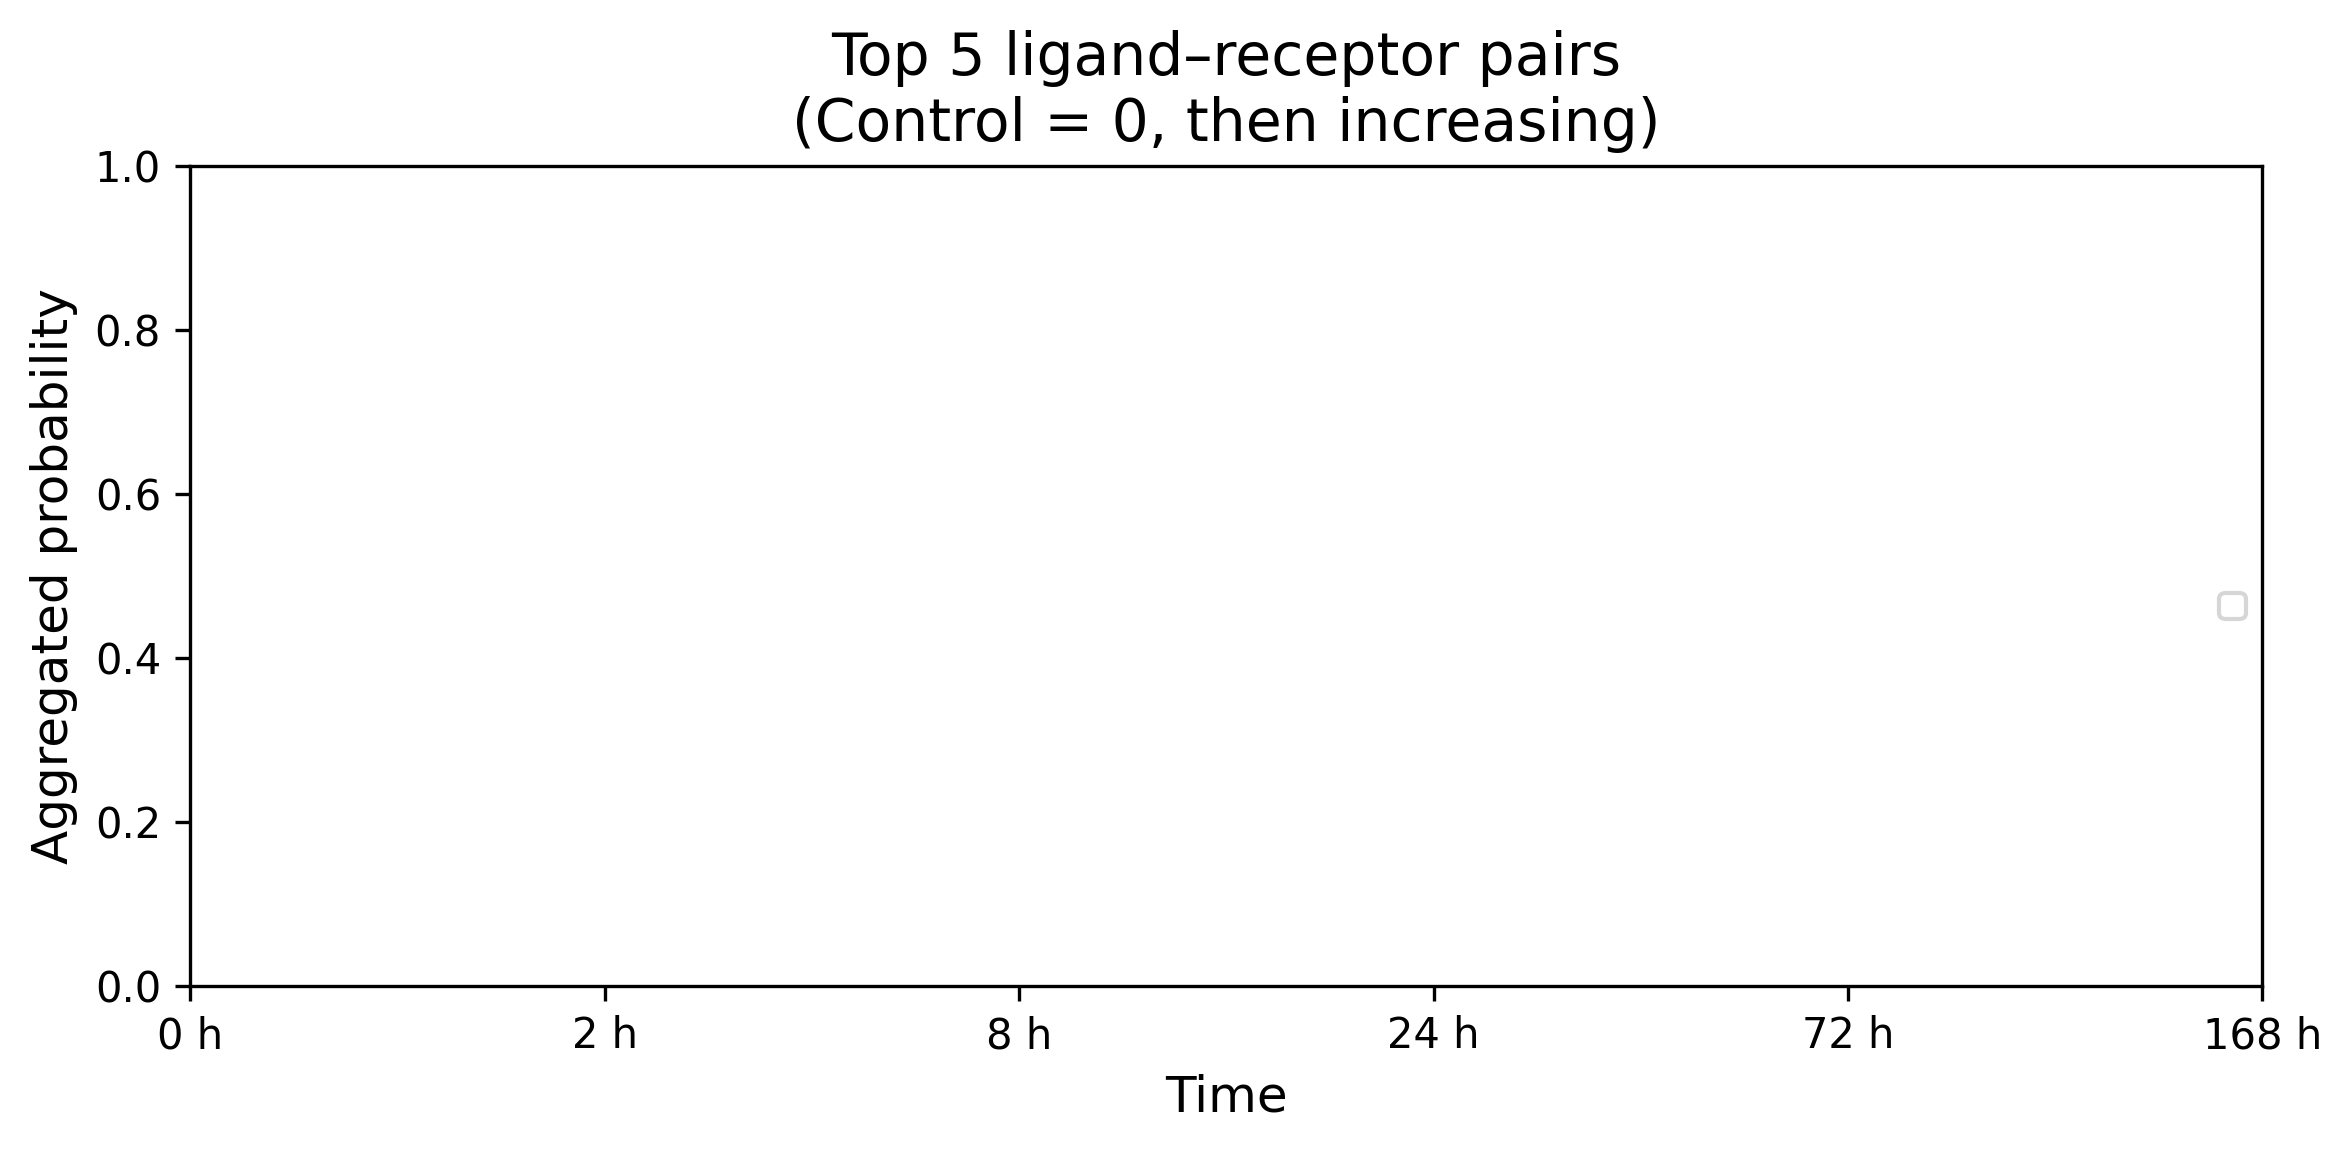

In [132]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 0. 假设 adata 已经读入，cellchat_output 在 adata.uns
cellchat = adata.uns["cellchat_output"]      # dict: time_key → DataFrame

# 1. 时间标签与小时数映射
time_map = {
    "onc1": "Control",    # Control
    "onc2": "ONC 2h",    # ONC 2h
    "onc3": "ONC 8h",    # ONC 8h
    "onc4": "ONC 1d",    # ONC 1d  
    "onc5": "ONC 3d",    # ONC 3d
    "onc6": "ONC 7d",    # ONC 7d
}

# 2. 抽取 RGC ↔ Endothelial（或你需要的细胞对）互作并聚合
records = []
for key, df in cellchat.items():
    if key not in time_map: continue
    t_h = time_map[key]
    sub = df[
        ((df.source == "RGC") & (df.target == "Microglia_Activated")) |
        ((df.source == "Microglia_Activated") & (df.target == "RGC"))
    ].copy()
    if sub.empty: continue
    agg = (
        sub.groupby(["ligand","receptor"])["prob"]
           .sum().reset_index()
    )
    agg["time_h"] = t_h
    agg["pair"]   = agg["ligand"] + " - " + agg["receptor"]
    records.append(agg[["pair","time_h","prob"]])

if not records:
    raise ValueError("在 RGC ↔ Endothelial 之间没有找到任何交互数据。")
long_df = pd.concat(records, ignore_index=True)

# 3. 透视成长×宽表：行=pair，列=time_h
pivot = long_df.pivot_table(
    index="pair", columns="time_h", values="prob", fill_value=0
)
pivot = pivot.reindex(columns=[0,2,8,24,72,168], fill_value=0)

# ——— 以下开始筛选 ———

# 1) 过滤：只要求 Control(0h) == 0
mask_initial_zero = (pivot[0] == 0)

# 2) 后续时点
time_pts = [8,24,72,168]

# 3) 计算增量
deltas = {t: pivot[t] - pivot[0] for t in time_pts}

# 4) 筛选：这四个时点 都要增量 > 0
mask_increase = pd.concat([deltas[t] > 0 for t in time_pts], axis=1).all(axis=1)

# 5) 合并条件
mask = mask_initial_zero & mask_increase

# 6) 提取完整六个时点的原始值
cols_all = [0,2] + time_pts
inc_all = pivot.loc[mask, cols_all].copy()

# 7) 计算 Δ 列 & sum(Δ)
for t in time_pts:
    inc_all[f"Δ{t}h"] = deltas[t][mask]
inc_all["sum(Δ)"] = inc_all[[f"Δ{t}h" for t in time_pts]].sum(axis=1)

# 8) 排序并展示
inc_all = inc_all.sort_values("sum(Δ)", ascending=False)
print("Pairs with Control=0 and increasing at 8h,24h,72h,168h:")
display(inc_all)

print("\nTop 5:")
top5 = inc_all.head(5)
display(top5)

# 9) 给 Top5 画折线图（包括 0h,2h 在内）
labels = ["0 h","2 h","8 h","24 h","72 h","168 h"]
pos    = np.arange(len(cols_all))

plt.figure(figsize=(8,4), dpi=300)
for pair, row in top5.iterrows():
    y = row[cols_all].values.astype(float)
    plt.plot(pos, y, marker='o', label=pair)

plt.xticks(pos, labels)
plt.xlabel("Time")
plt.ylabel("Aggregated probability")
plt.title("Top 5 ligand–receptor pairs\n(Control = 0, then increasing)")
plt.legend(bbox_to_anchor=(1,0.5), fontsize=8)
plt.tight_layout()
plt.show()

In [122]:
pivot

time_h,0,2,8,24,72,168
pair,,,,,,
Agrn - Dag1,0.001587,0.000000,0,0,0,0
App - Sorl1,0.023620,0.015991,0,0,0,0
Bdnf - Sort1,0.000999,0.000000,0,0,0,0
Cadm3 - Cadm1,0.034638,0.006429,0,0,0,0
Cdh12 - ITGA1_ITGB1,0.010687,0.017973,0,0,0,0
...,...,...,...,...,...,...
Tulp1 - Mertk,0.009756,0.000000,0,0,0,0
Vegfa - FLT1_KDR,0.000000,0.007668,0,0,0,0
Vegfa - Flt1,0.019240,0.023425,0,0,0,0


In [123]:
# 假设 pivot 已经是 RGC↔Microglia_Activated 的 “pair × time_h” 矩阵
# 列名为 [0, 2, 8, 24, 72, 168]，0 表示 Control, 后面分别是 2h,8h,1d,3d,7d

import pandas as pd

# 1) 计算每个时间点相对于 Control 的增量
time_pts = [2, 8, 24, 72, 168]
deltas = {t: pivot[t] - pivot[0] for t in time_pts}

# 2) 筛选：所有时间点都增量 > 0
mask = pd.concat([deltas[t] > 0 for t in time_pts], axis=1).all(axis=1)
inc_all = pivot.loc[mask, [0] + time_pts].copy()

# 3) 添加 Δ 列和总增幅
for t in time_pts:
    inc_all[f"Δ{t}h"] = deltas[t][mask]
inc_all["sum(Δ)"] = inc_all[[f"Δ{t}h" for t in time_pts]].sum(axis=1)

# 4) 排序并展示
inc_all = inc_all.sort_values("sum(Δ)", ascending=False)
print("Pairs increasing at all time points vs. Control:")
display(inc_all)

# （可选）只看 Top5
print("Top 5:")
display(inc_all.head(5))

Pairs increasing at all time points vs. Control:


time_h,0,2,8,24,72,168,Δ2h,Δ8h,Δ24h,Δ72h,Δ168h,sum(Δ)
pair,,,,,,,,,,,,


Top 5:


time_h,0,2,8,24,72,168,Δ2h,Δ8h,Δ24h,Δ72h,Δ168h,sum(Δ)
pair,,,,,,,,,,,,


In [124]:
import pandas as pd

# —— 假设 pivot 已经是 “pair × time” 矩阵，列 [0,2,8,24,72,168] —— 

# 1. 关注的四个时点
time_pts = [8, 24, 72, 168]

# 2. 计算增量
deltas = {t: pivot[t] - pivot[0] for t in time_pts}

# 3. 筛选：这四个时点增量 > 0，并且 Control(0) == 0
mask = (
    pd.concat([deltas[t] > 0 for t in time_pts], axis=1)
      .all(axis=1)
) & (pivot[0] == 0)

# 4. 取出 Control + 2h + 8h/24h/72h/168h 的原始 prob
cols = [0, 2] + time_pts
inc_all = pivot.loc[mask, cols].copy()

# 5. 再生成 Δ8h,Δ24h,Δ72h,Δ168h，并计算和
for t in time_pts:
    inc_all[f"Δ{t}h"] = deltas[t][mask]
inc_all["sum(Δ)"] = inc_all[[f"Δ{t}h" for t in time_pts]].sum(axis=1)

# 6. 排序 & 展示
inc_all = inc_all.sort_values("sum(Δ)", ascending=False)
print("Pairs with initial=0 and increasing at 8h,24h,72h,168h, with 2h re-added:")
display(inc_all)

Pairs with initial=0 and increasing at 8h,24h,72h,168h, with 2h re-added:


time_h,0,2,8,24,72,168,Δ8h,Δ24h,Δ72h,Δ168h,sum(Δ)
pair,,,,,,,,,,,


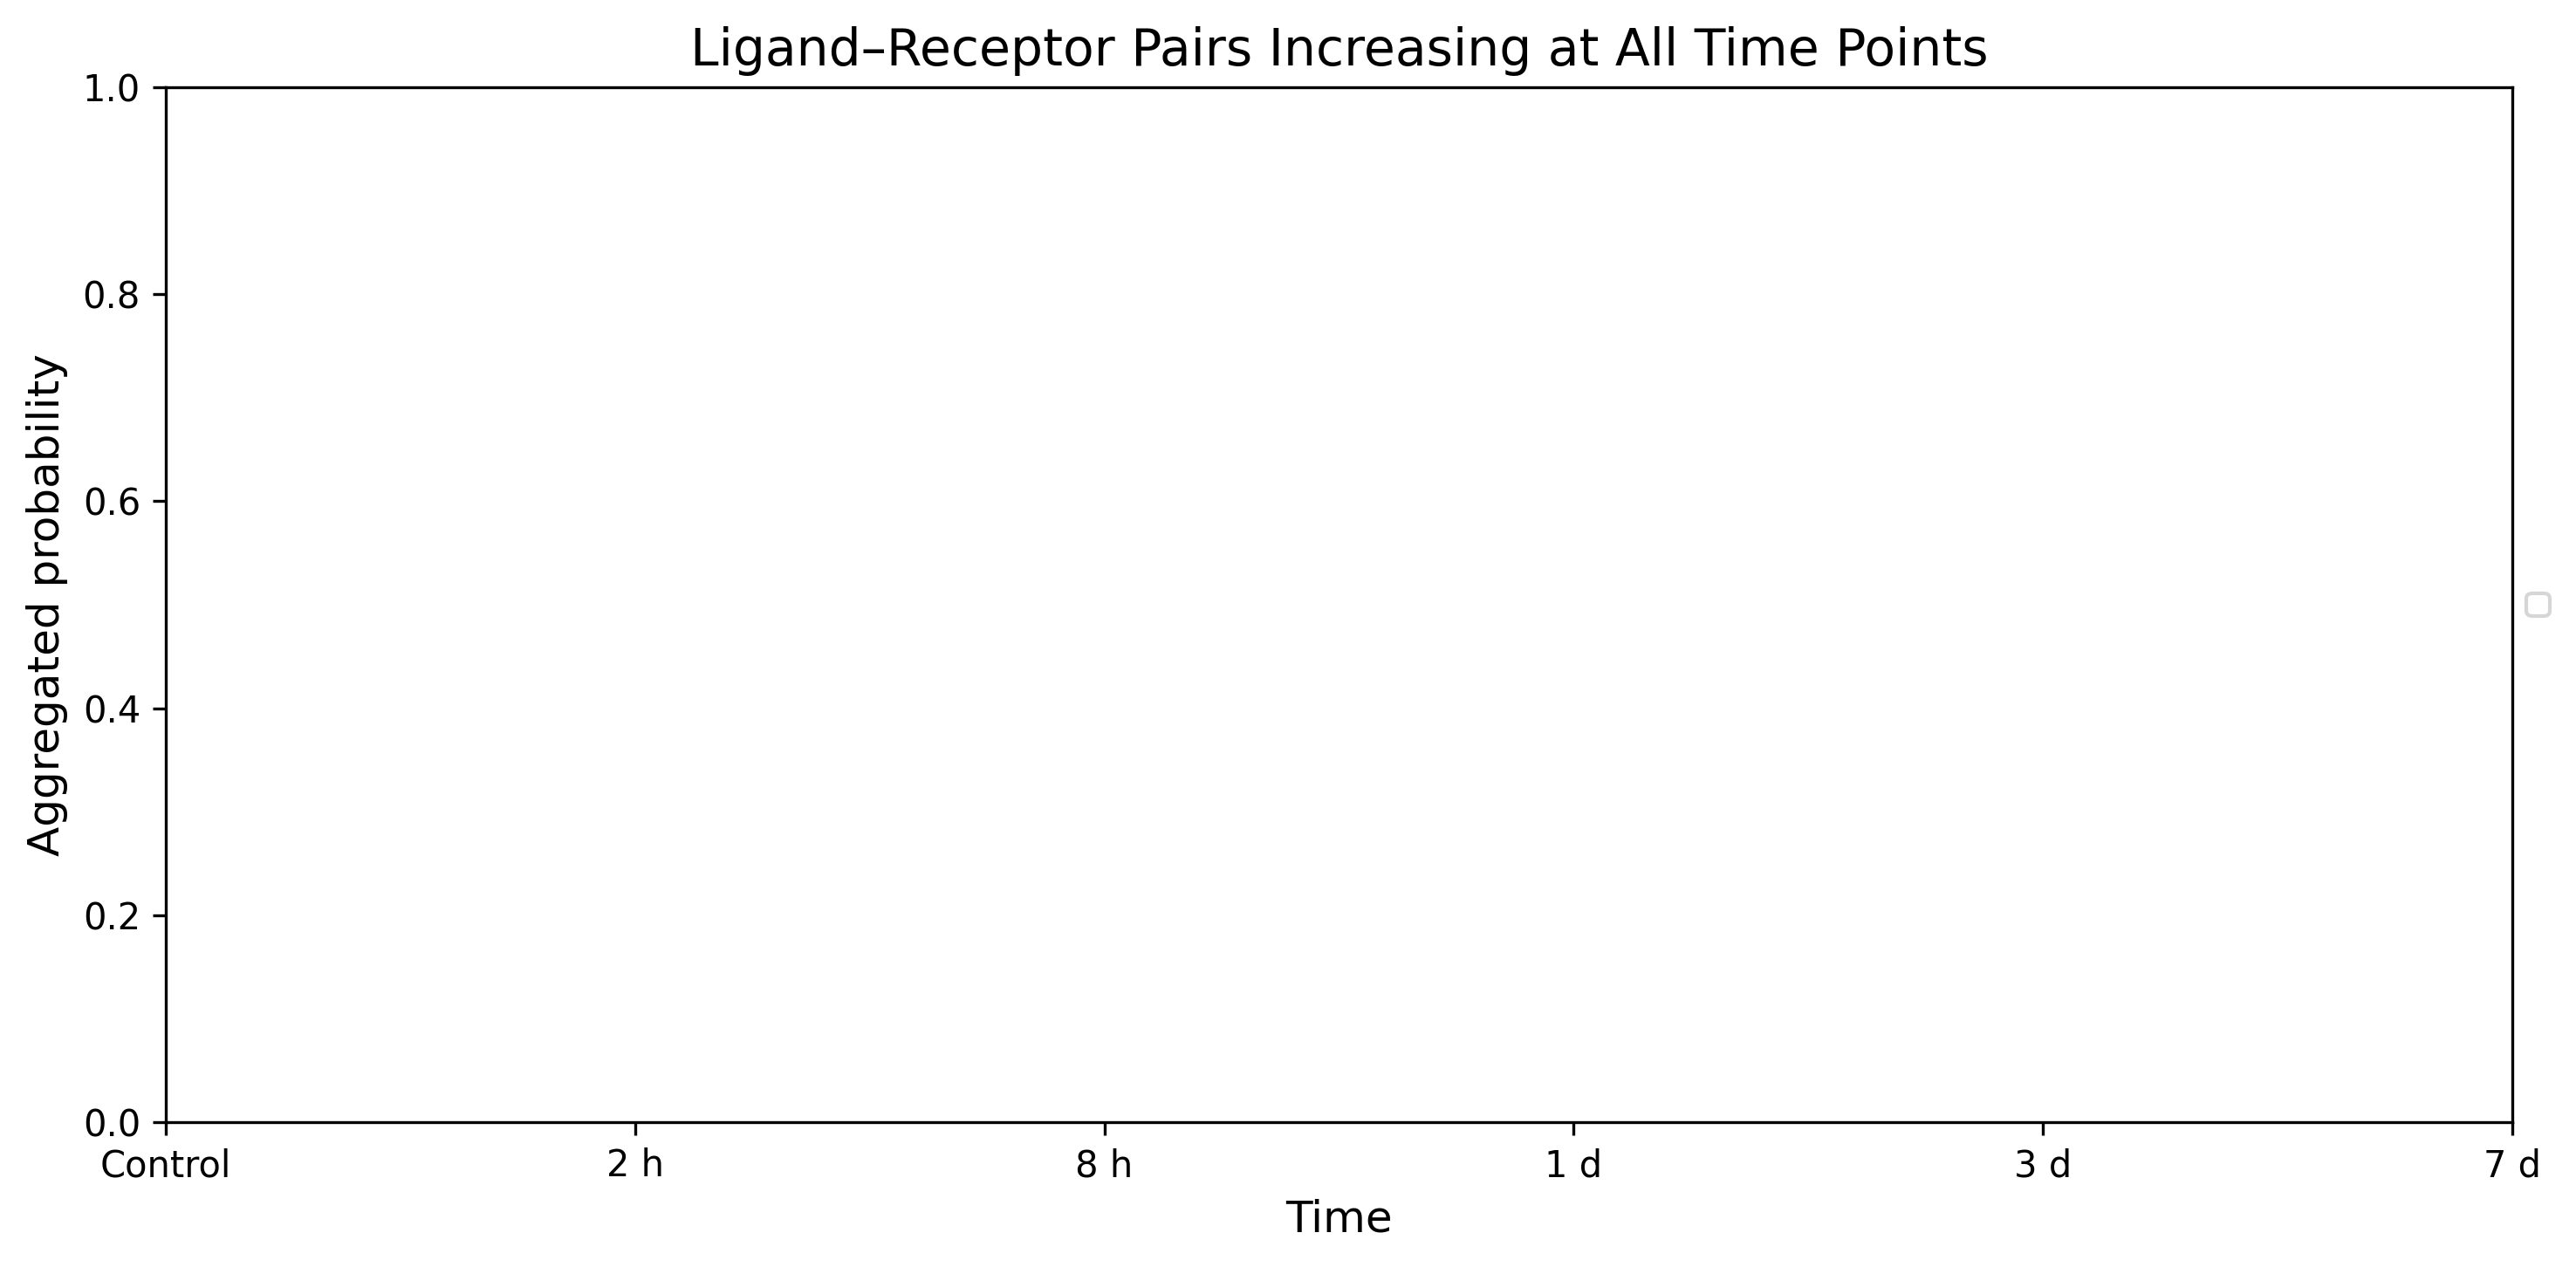

In [125]:
import matplotlib.pyplot as plt

# 假设 inc_all 已经准备好，index 是 “ligand - receptor”，
# 列名包含 [0,2,8,24,72,168]，分别是 Control,2h,8h,1d,3d,7d。

# 1) 定义原始时间点和等距位置
time_pts    = [0, 2, 8, 24, 72, 168]
time_labels = ["Control", "2 h", "8 h", "1 d", "3 d", "7 d"]
pos         = list(range(len(time_pts)))    # [0,1,2,3,4,5]

# 2) 绘制折线
plt.figure(figsize=(10,5),dpi=300)
for pair, row in inc_all.iterrows():
    y = row[time_pts].values.astype(float)
    plt.plot(pos, y, marker="o", label=pair)

# 3) 设置等距的刻度和标签
plt.xticks(pos, time_labels)
plt.xlabel("Time")
plt.ylabel("Aggregated probability")
plt.title("Ligand–Receptor Pairs Increasing at All Time Points")
plt.grid(False)

# 4) 图例放在右侧
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
print(adata.obs.columns.tolist())

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

df = pd.read_excel('GEM3_Flows_Expanded.xlsx', header=[0,1])
in_df  = df['In']
out_df = df['Out']

# 2. 获取时间点
timepoints = [tp for tp in in_df.columns if in_df[tp].notna().any()]
for tp in out_df.columns:
    if tp not in timepoints and out_df[tp].notna().any():
        timepoints.append(tp)
n_tp = len(timepoints)

# 3. 收集信号坐标
def get_positions(net_df, z):
    pos = {}
    for r, row in net_df.iterrows():
        for xi, tp in enumerate(timepoints):
            val = row.get(tp)
            if pd.notna(val):
                sig = str(val)
                pos.setdefault(sig, []).append((xi, r, z))
    return pos

in_pos  = get_positions(in_df, 1)
out_pos = get_positions(out_df, 0)
all_pos = {**in_pos, **out_pos}

# 4. Nature 调色板
palette = [
    '#3E5481','#2C7FB8','#6BAED6','#B2D8E8','#006837',
    '#66A61E','#B15928','#E6550D','#FD8D3C','#FDD0A2','#756BB1'
]

# 5. 绘图
fig = plt.figure(figsize=(12,24), dpi=300)
ax  = fig.add_subplot(111, projection='3d')
ax.grid(True, linestyle='--', alpha=0.5)
ax.yaxis._axinfo["grid"]['linewidth'] = 0

# 轴标签与刻度
ax.set_xlabel('Time')
ax.set_ylabel('Signal Index')
ax.set_zlabel('Network Level')
ax.set_xticks(range(n_tp))
ax.set_xticklabels(timepoints)
ax.set_zticks([0,1])
ax.set_zticklabels(['Out','In'])

# 长方体比例: X:Y:Z = 3:1:1
ax.set_box_aspect((3,6,3))

# 文本偏移与旋转

for i, (sig, coords) in enumerate(all_pos.items()):
    color = palette[i % len(palette)]
    coords_sorted = sorted(coords, key=lambda x: (x[2], x[0]))  # 按网络再按时间排序

    # 分别绘制 In (z=1) 和 Out (z=0)
    for z_level, marker in [(1, 'o'), (0, 's')]:
        pts = [(x,y,z) for x,y,z in coords_sorted if z == z_level]
        if len(pts) > 1:
            xs, ys, zs = zip(*pts)
            ax.plot(xs, ys, zs,
                    marker=marker, markersize=6,
                    linewidth=1.5, color=color)
            for x, y, z in pts:
                xl, yl, zl = x + dx, y + dy, z
                ax.plot([x, xl], [y, yl], [z, zl],
                        color=color, linewidth=0.5)
                ax.text(xl, yl, zl, sig,
                        size=6, ha='right', va='center',
                        rotation=rot)
        elif len(pts) == 1:
            x, y, z = pts[0]
            ax.scatter(x, y, z, s=30, c=color, marker=marker)

plt.tight_layout()
plt.show()

NameError: name 'dx' is not defined

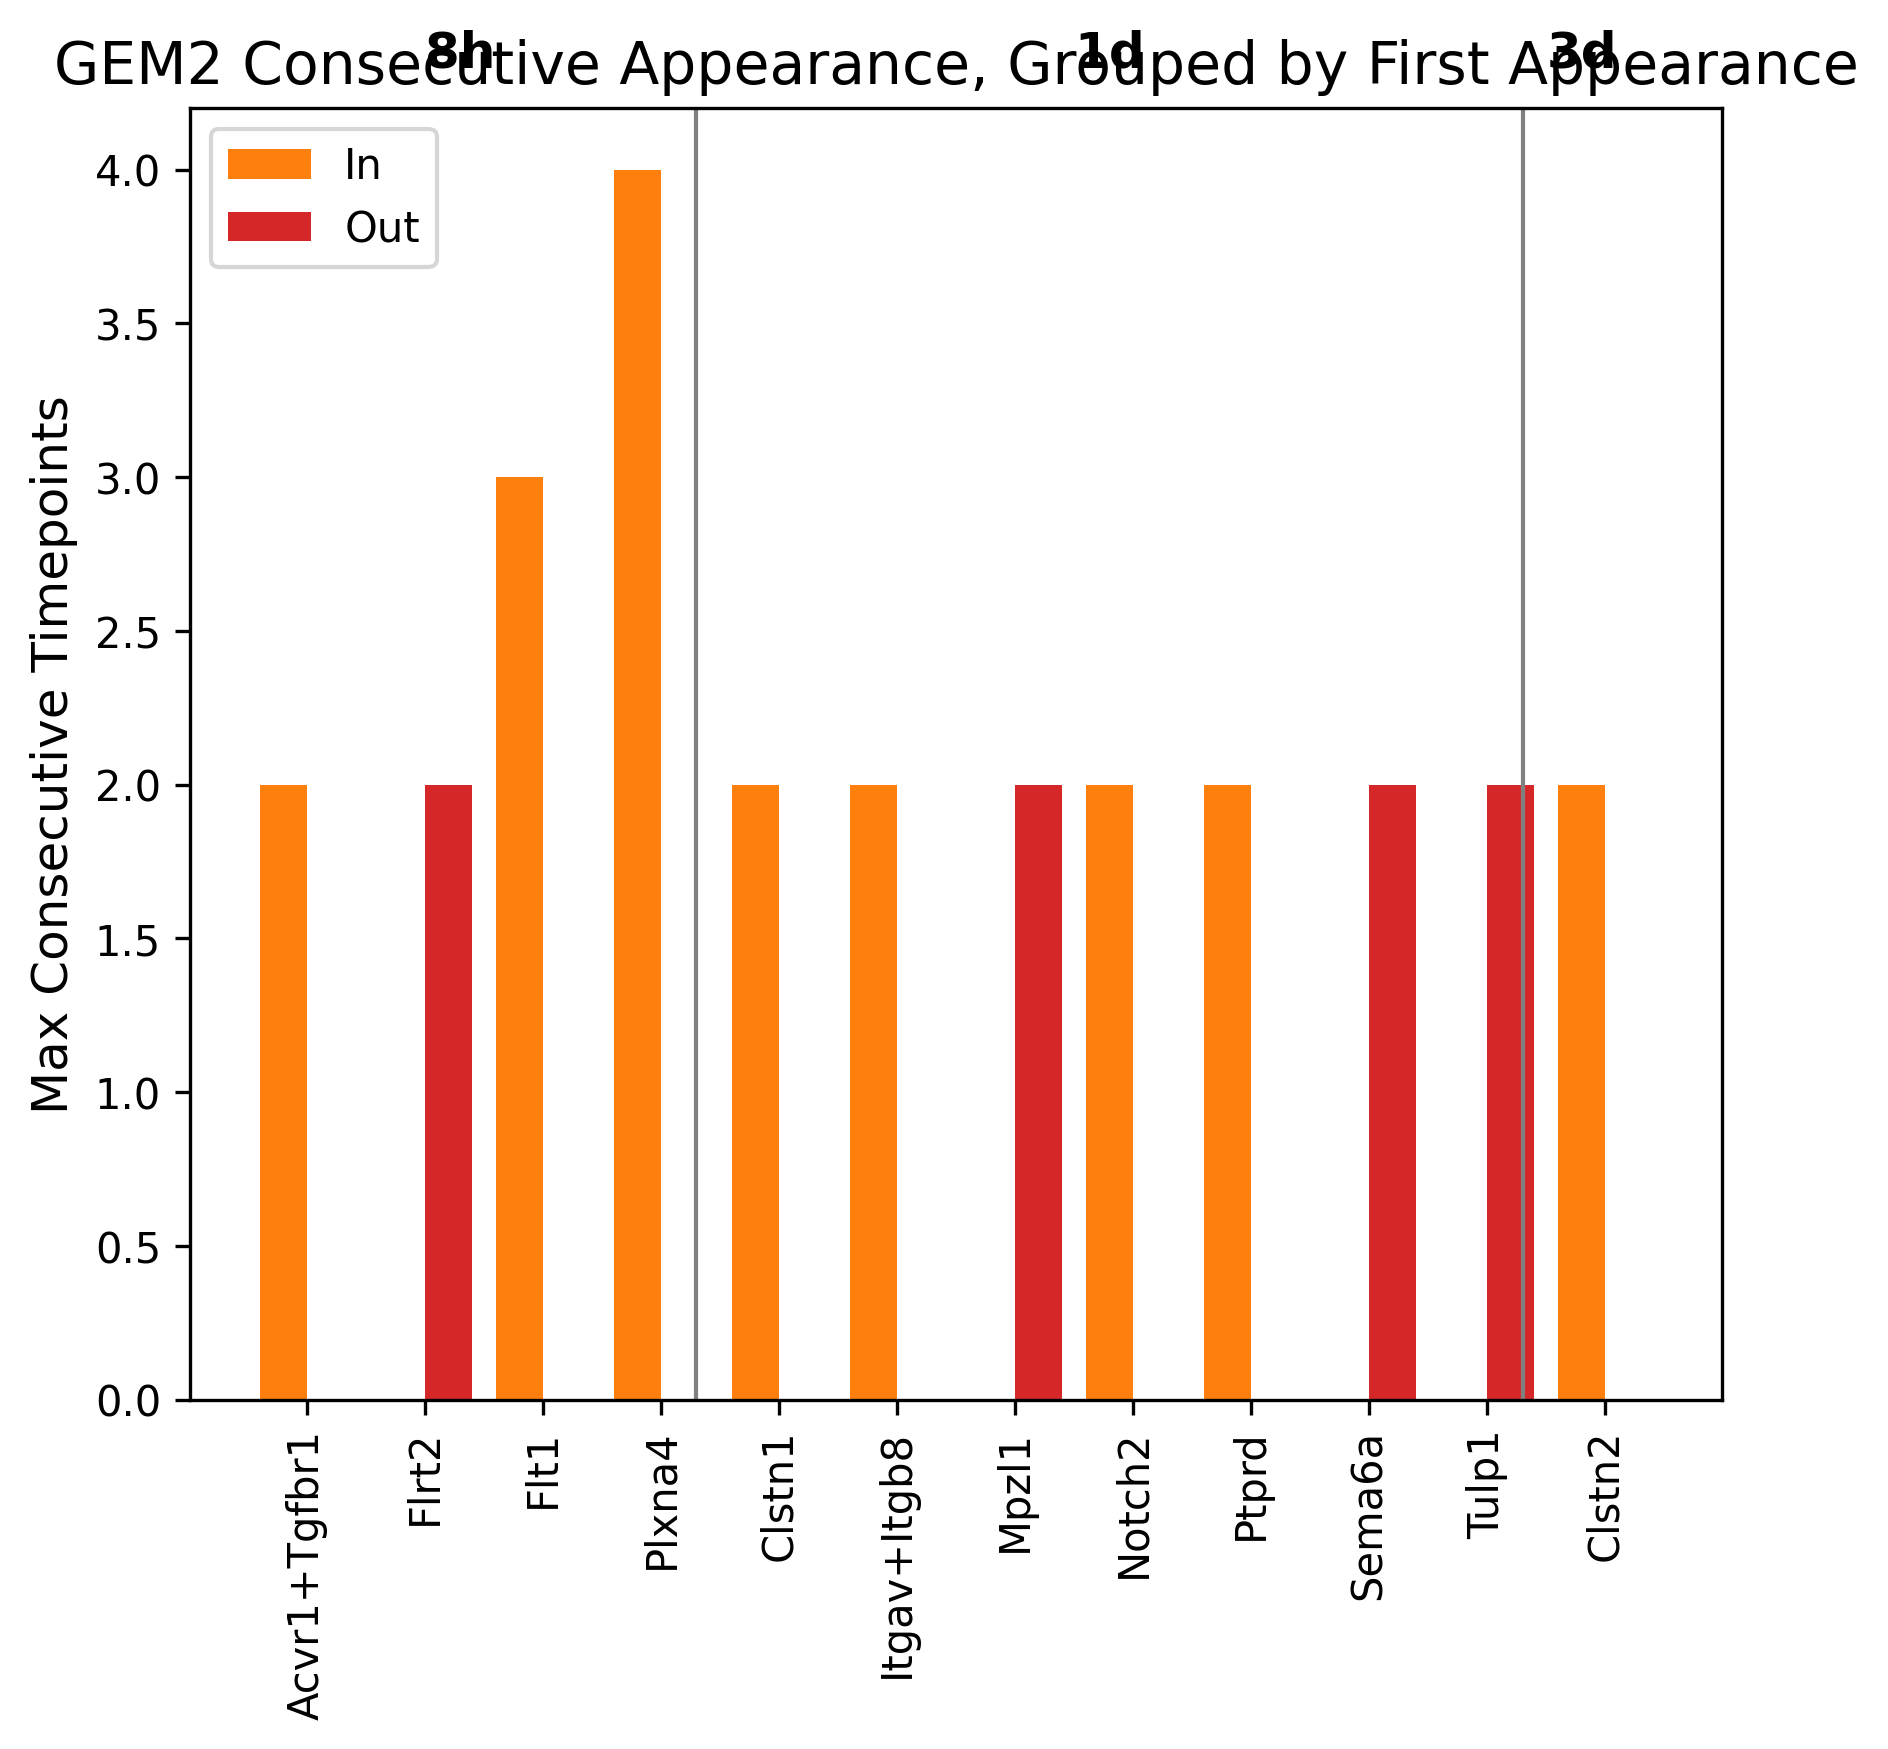

In [111]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# --- 准备 GEM6 数据 ---
# 1. 读取 GEM2（双行表头）
file_path = 'GEM2_Flows_Expanded.xlsx'
df2 = pd.read_excel(file_path, header=[0,1])

# 2. 拆分 In/Out 子表
in_df  = df2['In']
out_df = df2['Out']

# 3. 提取时间点列表（使用 Out 表的列，去除重复的 “7d.1”）
timepoints = out_df.columns.tolist()

# 4. 按时间点聚合 Ligands/Receptors
ligands   = []
receptors = []
for tp in timepoints:
    # In 流入信号
    li = in_df[tp].dropna().astype(str).tolist()
    ligands.append(', '.join(li))
    # Out 流出信号
    ro = out_df[tp].dropna().astype(str).tolist()
    receptors.append(', '.join(ro))

# 5. 构建 data 字典
data = {
    'Timepoint':  timepoints,
    'Ligands':    ligands,
    'Receptors':  receptors
}

# 6. 转为 DataFrame 并预览
df = pd.DataFrame(data)

# --- 拆分为列表 ---
df['Ligands']   = df['Ligands'].apply(lambda s: [it.strip() for it in re.split(r'[;,；]\s*', s) if it.strip()])
df['Receptors'] = df['Receptors'].apply(lambda s: [it.strip() for it in re.split(r'[;,；]\s*', s) if it.strip()])

# --- 构造出现索引 ---
def build_appearances(col):
    app = {}
    for ti, row in df.iterrows():
        for sig in row[col]:
            app.setdefault(sig, []).append(ti)
    return app

in_app  = build_appearances('Ligands')
out_app = build_appearances('Receptors')

def build_appearances(col):
    app = {}
    for ti, row in df.iterrows():
        for sig in row[col]:
            app.setdefault(sig, []).append(ti)
    return app

in_app  = build_appearances('Ligands')
out_app = build_appearances('Receptors')

# --- 统计 & 首次出现 & 最长连续 ---
def max_consecutive(idx_list):
    if not idx_list: return 0
    idxs = sorted(set(idx_list))
    cur = best = 1
    for a, b in zip(idxs, idxs[1:]):
        if b == a+1:
            cur += 1
        else:
            cur = 1
        best = max(best, cur)
    return best

records = []
for sig in sorted(set(in_app) | set(out_app)):
    idx_in  = sorted(set(in_app.get(sig, [])))
    idx_out = sorted(set(out_app.get(sig, [])))
    tot_in  = len(idx_in)
    tot_out = len(idx_out)
    # 计算最长连续
    con_in  = max_consecutive(idx_in)
    con_out = max_consecutive(idx_out)
    # 只保留没有断档的信号序列（且至少出现 2 次）
    if (con_in == tot_in and tot_in > 1) or (con_out == tot_out and tot_out > 1):
        first = min(idx_in + idx_out)
        records.append({
            'Signal':       sig,
            'First_Appear': first,
            'In_Consec':    con_in if con_in == tot_in else 0,
            'Out_Consec':   con_out if con_out == tot_out else 0
        })

stats_df = pd.DataFrame(records)
# 按首次出现升序排列
stats_df.sort_values('First_Appear', inplace=True)
stats_df.reset_index(drop=True, inplace=True)
stats_df = stats_df[(stats_df['In_Consec'] > 1) | (stats_df['Out_Consec'] > 1)]
# --- 分组边界 ---
group_sizes = stats_df['First_Appear'].value_counts().sort_index().cumsum()
group_labels = [timepoints[i] for i in group_sizes.index]

# --- 可视化 ---
fig, ax = plt.subplots(figsize=(6,6),dpi =300)
x = np.arange(len(stats_df))
w = 0.4

ax.bar(x,       stats_df['In_Consec'],  w, label='In',  color='tab:orange')
ax.bar(x + w,   stats_df['Out_Consec'], w, label='Out', color='tab:red')

# 绘制分隔线 & 标注组
for b in group_sizes[:-1]:
    ax.axvline(b - 0.5, color='grey', linewidth=1)
start = 0
for size, label in zip(group_sizes, group_labels):
    mid = (start + size - 1) / 2
    ax.text(mid, ax.get_ylim()[1] + 0.1, label,
            ha='center', va='bottom', weight='bold')
    start = size

ax.set_xticks(x + w/2)
ax.set_xticklabels(stats_df['Signal'], rotation=90)
ax.set_ylabel('Max Consecutive Timepoints')
ax.set_title('GEM2 Consecutive Appearance, Grouped by First Appearance')
ax.legend()
plt.tight_layout()
plt.show()

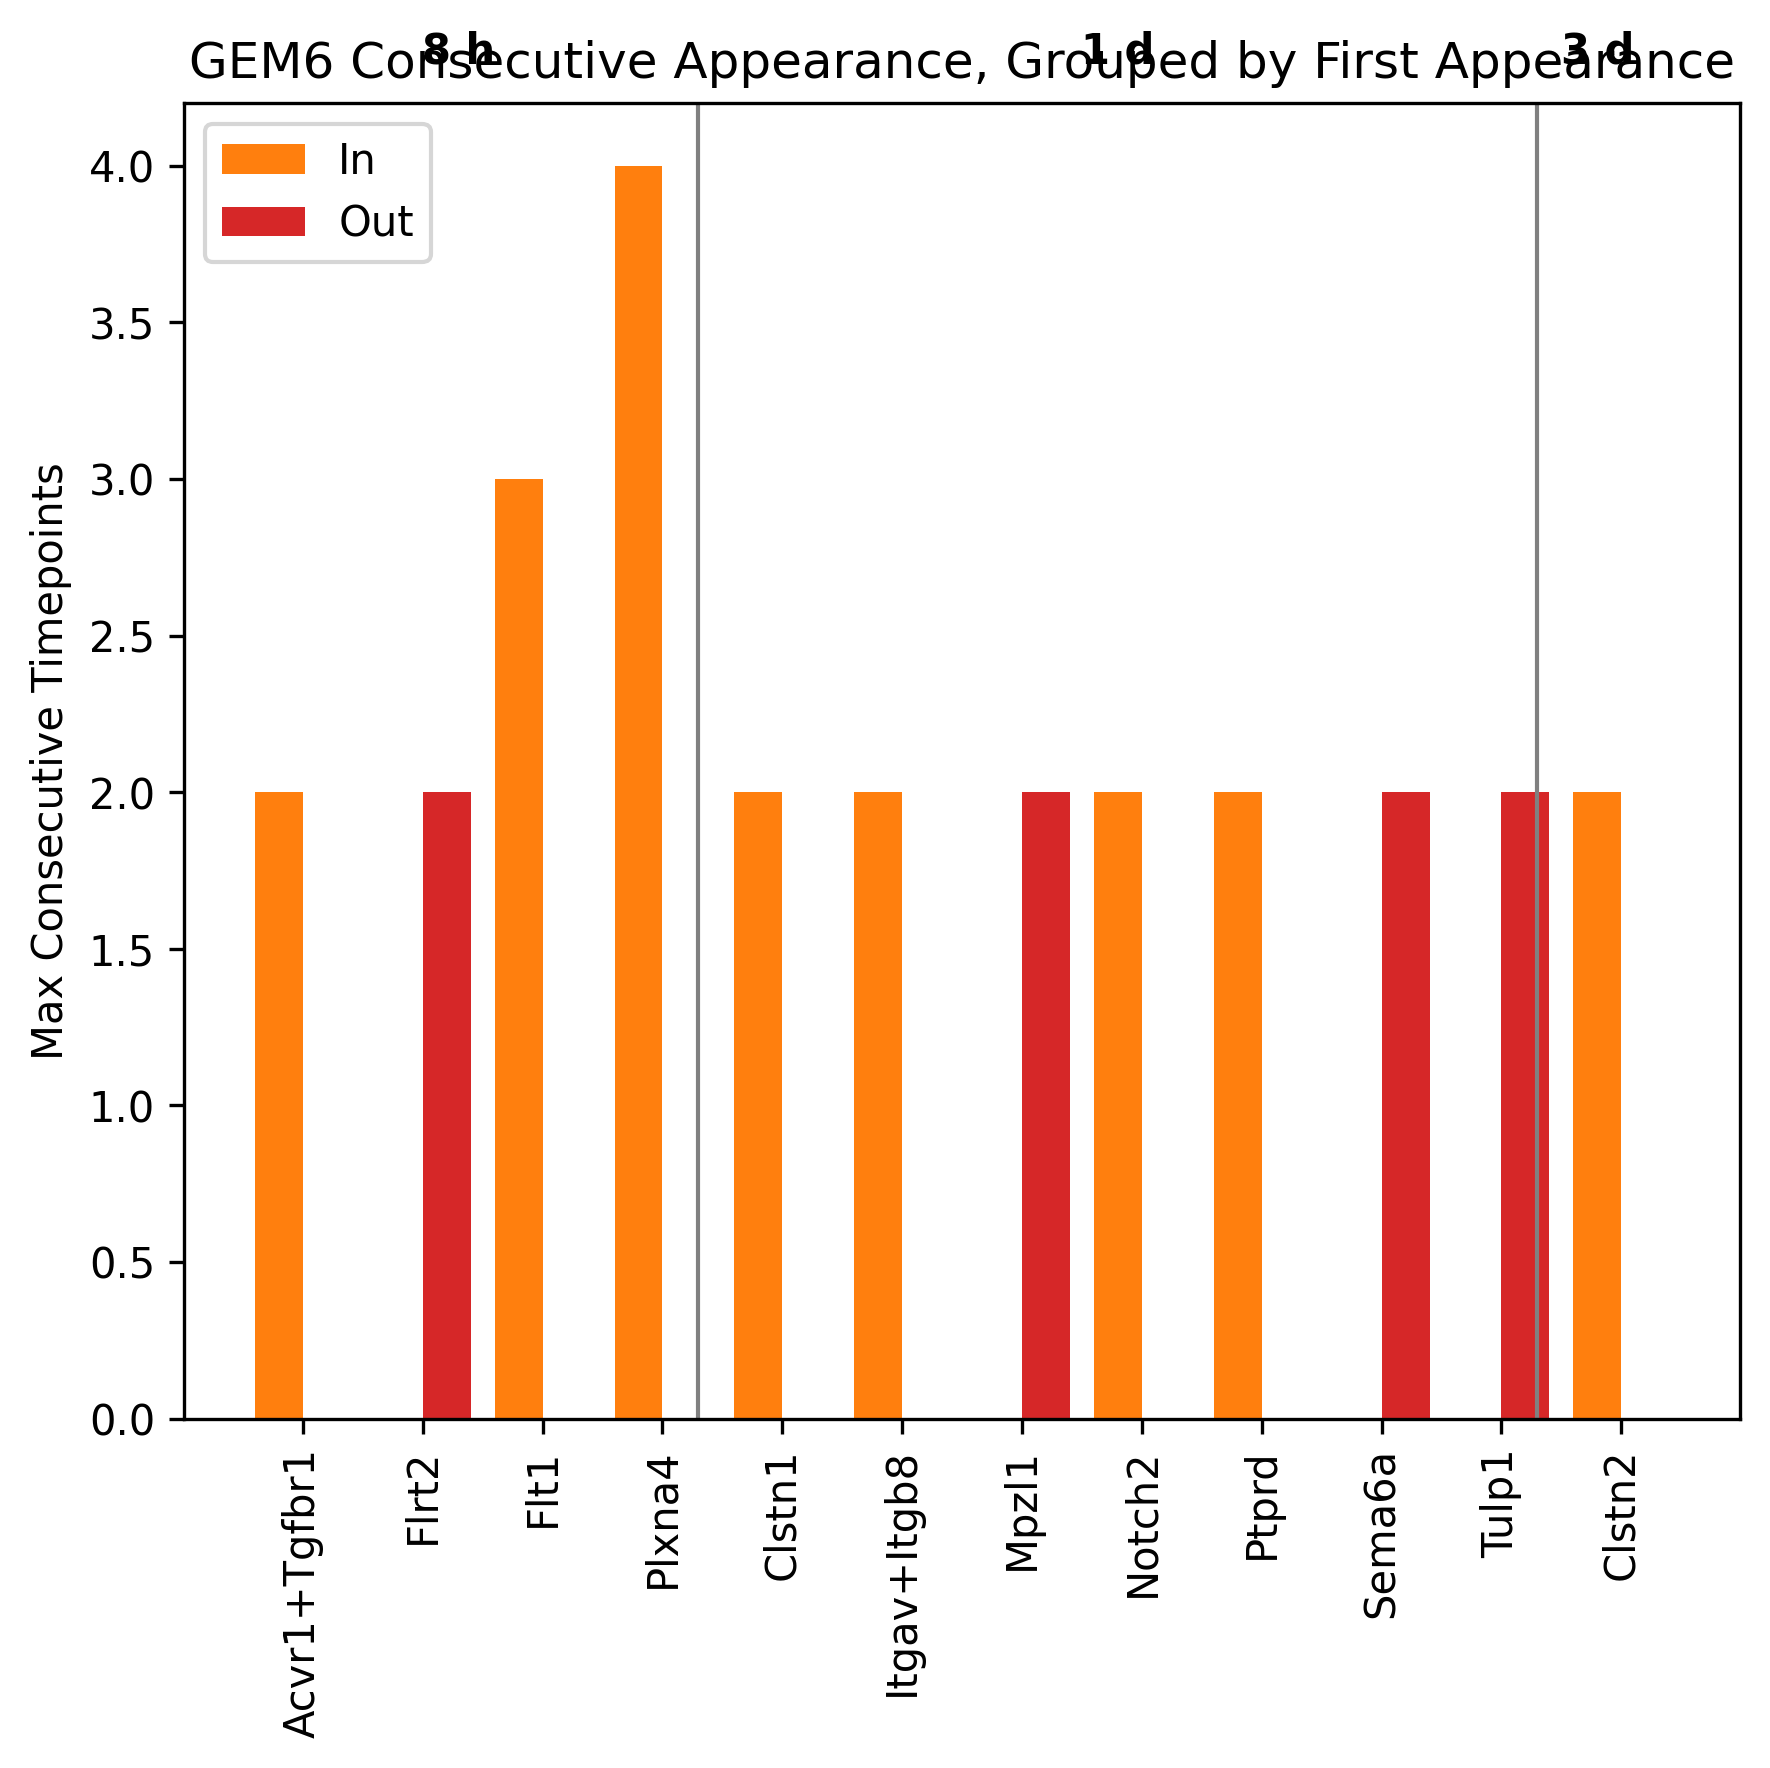

In [1038]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

# GEM2 时间点与数据集构建

# 1. 时间点列表
timepoints = ['2 h', '8 h', '1 d', '3 d', '7 d']

# 2. 原始数据字典
data = {
    'Timepoint': timepoints,
    'Ligands': [
        'Ocln, Cd38',
        'Robo2, Plxna4, Notch1, Nlgn1, Grm8, Grm7, Grik2+Grik5, Grik2+Grik4, Grik2, Flt1, Acvr1+Tgfbr1',
        'Unc5c, Tgfbr1+Tgfbr2, Tek, Ptprz1, Ptprd, Pdgfrb, Ntrk3, Plxna2, Plxna4, Notch2, Nectin3, Mertk, Itgav+Itgb8, Itgav+Itgb5, Itgav+Itgb1, Itga9+Itgb1, Itga8+Itgb1, Igf1r, Grm8, Grin1+Grin2b, Grik3+Grik5, Grik3+Grik4, Grik1+Grik5, Grik1+Grik4, Flt1, Fgfr1, Epha3, Egfr, Dag1, Csf1r, Clstn1, Chrna7, Cd36, Bsg, Bmpr1b+Bmpr2, Bmpr1a+Bmpr2, Adgrl2, Acvr1+Tgfbr1, Acvr1+Bmpr2, Acvr1+Acvr2a',
        'Vldlr, Trem2+Tyrobp, Ptprm, Ptprd, Plxna4, Notch2, Kdr, Itgav+Itgb8, Itga5+Itgb1, Itga4+Itgb1, Fzd6, Flt1, Clstn2, Clstn1',
        'Unc5c, Tgfbr1+Tgfbr2, Plxna4, Pdgfrb, Nectin3, Ncam2, Ncam1, Itgav+Itgb5, Itgav+Itgb1, Grm8, Gabra2, Cx3cr1, Csf1r, Clstn2, Bsg'
    ],
    'Receptors': [
        'Col9a1',  # 无明确标注
        'Tenm3, Pdgfd, Nrxn3, Nrxn1, Nrg3, Nfasc, Lrrtm4, Lrrc4c, Lama2, Flrt2, Cx3cr1, Col9a1, Col4a5, Col4a2, Col4a1, Cdh2, Cadm1, C1ql1, Bdnf',
        'Vtn, Tulp1, Sema6a, Sdc2, Prnp, Ntn4, Mpzl1, Lamc1, Jam2, Flrt2, Col2a1, Bmp5',
        'Tulp1, Sema6a, Pecam1, Nfasc, Mpzl1, Kitl, Col4a6, Col4a1, C1ql1',
        'Thy1, Pros1, Ppia, Lrfn5, Cx3cl1, Col9a1, Col2a1, Cdh2'
    ]
}

# 3. 转为 DataFrame 示例
import pandas as pd
df = pd.DataFrame(data)

# --- 拆分为列表 ---
df['Ligands']   = df['Ligands'].apply(lambda s: [it.strip() for it in re.split(r'[;,；]\s*', s) if it.strip()])
df['Receptors'] = df['Receptors'].apply(lambda s: [it.strip() for it in re.split(r'[;,；]\s*', s) if it.strip()])

# --- 构造出现索引 ---
def build_appearances(col):
    app = {}
    for ti, row in df.iterrows():
        for sig in row[col]:
            app.setdefault(sig, []).append(ti)
    return app

in_app  = build_appearances('Ligands')
out_app = build_appearances('Receptors')

# --- 统计 & 首次出现 & 最长连续 ---
def max_consecutive(idx_list):
    if not idx_list: return 0
    idxs = sorted(set(idx_list))
    cur = best = 1
    for a, b in zip(idxs, idxs[1:]):
        if b == a+1:
            cur += 1
        else:
            cur = 1
        best = max(best, cur)
    return best

records = []
for sig in sorted(set(in_app) | set(out_app)):
    idx_in  = sorted(set(in_app.get(sig, [])))
    idx_out = sorted(set(out_app.get(sig, [])))
    tot_in  = len(idx_in)
    tot_out = len(idx_out)
    # 计算最长连续
    con_in  = max_consecutive(idx_in)
    con_out = max_consecutive(idx_out)
    # 只保留没有断档的信号序列（且至少出现 2 次）
    if (con_in == tot_in and tot_in > 1) or (con_out == tot_out and tot_out > 1):
        first = min(idx_in + idx_out)
        records.append({
            'Signal':       sig,
            'First_Appear': first,
            'In_Consec':    con_in if con_in == tot_in else 0,
            'Out_Consec':   con_out if con_out == tot_out else 0
        })

stats_df = pd.DataFrame(records)
# 按首次出现升序排列
stats_df.sort_values('First_Appear', inplace=True)
stats_df.reset_index(drop=True, inplace=True)
stats_df = stats_df[(stats_df['In_Consec'] > 1) | (stats_df['Out_Consec'] > 1)]
# --- 分组边界 ---
group_sizes = stats_df['First_Appear'].value_counts().sort_index().cumsum()
group_labels = [timepoints[i] for i in group_sizes.index]

# --- 可视化 ---
fig, ax = plt.subplots(figsize=(6,6),dpi =300)
x = np.arange(len(stats_df))
w = 0.4

ax.bar(x,       stats_df['In_Consec'],  w, label='In',  color='tab:orange')
ax.bar(x + w,   stats_df['Out_Consec'], w, label='Out', color='tab:red')

# 绘制分隔线 & 标注组
firsts = stats_df['First_Appear'].values
# diff != 0 的地方就是新组开始，在它之后画线
boundaries = np.where(np.diff(firsts) != 0)[0] + 1

# 画分隔线
for b in boundaries:
    ax.axvline(b - 0.5, color='grey', linewidth=1)

# 画组标签
start = 0
for b in np.append(boundaries, len(stats_df)):
    # 组从 start 到 b-1
    mid = (start + (b-1)) / 2
    label = timepoints[stats_df.loc[start, 'First_Appear']]
    ax.text(mid, ax.get_ylim()[1] + 0.1, label,
            ha='center', va='bottom', weight='bold')
    start = b

ax.set_xticks(x + w/2)
ax.set_xticklabels(stats_df['Signal'], rotation=90)
ax.set_ylabel('Max Consecutive Timepoints')
ax.set_title('GEM6 Consecutive Appearance, Grouped by First Appearance')
ax.legend()
plt.tight_layout()
plt.show()